In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from urllib.request import urlretrieve
from scipy.stats import pearsonr

from config.config import DATA_PATH
pd.set_option('display.max_columns', None)

In [2]:
X_train = pd.read_csv(DATA_PATH + '/modeling/X_train.csv')
X_test = pd.read_csv(DATA_PATH + '/modeling/X_test.csv')
y_train = pd.read_csv(DATA_PATH + '/modeling/y_train.csv')
y_test = pd.read_csv(DATA_PATH + '/modeling/y_test.csv')

In [3]:
y_train = y_train['cancelled']
y_test = y_test['cancelled']

In [4]:
X_train.head()

,quarter,month,day_of_month,day_of_week,hour_of_day,scheduled_elapsed_time,distance,dep_delay_mean_10D,dep_delay_median_10D,dep_delay_max_10D,arr_delay_median_10D,cancelled_sum_10D,div_airport_landings_sum_10D,n_flights_10D,dep_delay_mean_30D,dep_delay_median_30D,dep_delay_max_30D,arr_delay_median_30D,cancelled_sum_30D,div_airport_landings_sum_30D,cancelled_sum_90D,div_airport_landings_sum_90D,temperature_2m_origin,precipitation_origin,snow_depth_origin,weather_code_origin,visibility_origin,wind_speed_10m_origin,wind_direction_10m_origin,wind_gusts_10m_origin,temperature_2m_dest,precipitation_dest,snow_depth_dest,weather_code_dest,visibility_dest,wind_speed_10m_dest,wind_direction_10m_dest,wind_gusts_10m_dest,origin_encoded,dest_encoded,airline_mkt_encoded,airline_ops_encoded,origin_division_encoded,dest_division_encoded,code_share_flight,is_holiday,dep_window_early afternoon,dep_window_early morning,dep_window_evening,dep_window_late night,dep_window_midday,dep_window_morning,dep_window_night,dep_window_overnight
0,-1.361845,-1.620543,-1.452345,-0.984862,0.189847,-0.031459,1.937362,0.617993,2.272436,-0.369399,1.263474,-0.320950,-0.02657,-1.252609,0.753796,2.917779,-0.651917,1.595429,-0.455432,-0.045443,-0.614674,-0.075479,0.942484,-0.059526,-0.098763,-0.279899,-0.691314,1.486775,-0.662031,0.439144,-0.384728,-0.061437,-0.097708,-0.151443,-0.923607,0.334950,-1.025207,0.658845,0.725836,-0.927173,0.758972,0.686502,-0.373972,-1.033742,0,0,1,0,0,0,0,0,0,0
1,-0.462343,-0.450140,1.515007,-1.485173,-0.797123,-0.935554,-1.309607,-0.714057,-0.334788,-0.688254,-0.571252,-0.320950,-0.02657,0.282212,-0.720075,-0.326840,-0.544094,-0.447513,-0.455432,-0.045443,-0.247148,-0.075479,0.140555,-0.059526,-0.098763,-0.156940,-0.587775,0.382257,1.248121,-0.070664,0.032863,-0.061437,-0.097708,-0.151443,-0.965718,-0.207061,0.605140,-0.767828,-0.917549,-0.948258,-0.513727,-0.710339,-0.373972,-0.389142,0,1,0,0,0,0,0,1,0,0
2,0.437160,0.720262,0.031331,1.016382,0.979423,-0.067265,-0.193030,0.215444,0.056296,0.718457,-0.031627,-0.320950,-0.02657,0.172582,0.228256,0.078737,0.592533,-0.118006,-0.455432,-0.045443,-0.614674,-0.075479,0.241497,-0.059526,-0.098763,-0.156940,-0.804266,-0.080100,0.878091,-0.509665,-0.119502,-0.061437,-0.097708,-0.336215,-0.521212,-0.542592,1.118397,-0.598323,-0.904235,-1.189224,-1.777531,-1.078380,-1.020498,-1.033742,0,0,0,0,1,0,0,0,0,0
3,1.336662,1.012863,-1.452345,-0.984862,-0.402335,-0.774428,-1.139360,-0.896203,-0.660691,-0.688254,-0.598233,-0.320950,-0.02657,-0.485198,-1.015863,-0.651302,-0.822635,-0.645217,-0.455432,-0.045443,-0.614674,-0.075479,0.348047,-0.059526,-0.098763,-0.156940,-0.423054,-0.388337,-1.282081,-1.019473,0.591532,-0.061437,-0.097708,-0.336215,-0.563323,0.231709,0.746034,-0.598323,-0.548545,-0.927173,-0.640548,-0.291071,-1.020498,-1.033742,1,0,0,0,0,0,1,0,0,0
4,-1.361845,-1.327942,1.172621,1.516693,0.979423,-0.872894,-1.351018,0.966584,0.871053,0.218293,1.884043,1.237885,-0.02657,-0.485198,-0.143768,-0.326840,-0.229612,0.738711,1.070058,-0.045443,0.120378,-0.075479,-0.779140,-0.059526,-0.098763,-0.341378,0.682932,0.921673,0.378051,1.642857,-0.830535,-0.061437,-0.097708,-0.336215,-0.086064,-0.955553,0.675587,-0.852581,2.519309,0.172827,0.822719,3.870703,2.156194,-0.389142,1,0,0,0,1,0,0,0,0,0


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
logreg_model = LogisticRegression()

logreg_model.fit(X_train, y_train)

y_pred = logreg_model.predict(X_test)

print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    441319
           1       0.24      0.04      0.06      6416

    accuracy                           0.98    447735
   macro avg       0.61      0.52      0.53    447735
weighted avg       0.98      0.98      0.98    447735


[[440541    778]
 [  6176    240]]


In [7]:
rf_model = RandomForestClassifier()

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    441319
           1       0.84      0.15      0.25      6416

    accuracy                           0.99    447735
   macro avg       0.91      0.57      0.62    447735
weighted avg       0.99      0.99      0.98    447735


[[441130    189]
 [  5451    965]]


In [8]:
model_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_test.columns)
model_important_features = model_important_features.sort_values('feature_importance', ascending=False)
model_important_features.head(20)

,feature_importance
cancelled_sum_10D,0.079835
n_flights_10D,0.039541
temperature_2m_origin,0.037087
visibility_origin,0.036816
visibility_dest,0.036426
day_of_month,0.035783
temperature_2m_dest,0.035683
wind_gusts_10m_origin,0.032971
wind_gusts_10m_dest,0.032191
wind_direction_10m_dest,0.031621


In [ ]:
gb_model = GradientBoostingClassifier()

gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)

print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))

In [62]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import KFold, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [74]:
model_results = []

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model
    model_fit = model.fit(X_train, y_train)
    
    # Predict
    y_pred = model_fit.predict(X_test)
    y_pred_proba = model_fit.predict_proba(X_test)[:, 1]

    # calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    auprc = average_precision_score(y_test, y_pred_proba)
    
    # Return the metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'auprc': auprc
    }

In [75]:
def grid_search_model(model, params, X_train, y_train):

    kf = KFold(n_splits=3, shuffle=True, random_state=40)

    gs = GridSearchCV(model, param_grid=params, cv=kf, scoring='f1', n_jobs=-1)

    gs_fit = gs.fit(X_train, y_train)

    best_estimator, best_params = gs_fit.best_estimator_, gs_fit.best_params_

    return best_estimator, best_params

In [76]:
from sklearn.model_selection import RandomizedSearchCV

def random_grid_search_model(model, params, X_train, y_train):

    kf = KFold(n_splits=3, shuffle=True, random_state=40)

    rs  = RandomizedSearchCV(model, params, n_iter=50, n_jobs=-1, cv=kf)

    rs_fit = rs.fit(X_train, y_train)

    best_estimator, best_params = rs_fit.best_estimator_, rs_fit.best_params_

    return best_estimator, best_params

In [ ]:
log_reg_param_grid = {
   # 'penalty': ['l1', 'l2'],
    'C': np.logspace(-2, 2, 10),
    'solver': ['saga', 'newton-cholesky'], 
    'max_iter': [700],
}

best_model, best_params = grid_search_model(model=LogisticRegression(), 
                                            params=log_reg_param_grid, 
                                            X_train=X_train, 
                                            y_train=y_train)

logreg_metrics = evaluate_model(best_model, X_train, y_train, X_test, y_test)
logreg_metrics['model'] = 'LogisticRegression_GS'
logreg_metrics['best_params'] = best_params
model_results.append(logreg_metrics)

In [19]:
results_df = pd.DataFrame(model_results)
results_df.sort_values('recall', ascending=False)
results_df

,accuracy,precision,recall,f1,roc_auc,auprc,model,best_params
0,0.984486,0.237103,0.037251,0.064386,0.906372,0.1658,LogisticRegression_GS,"{'max_iter': 700, 'solver': 'newton-cholesky'}"


In [ ]:
rf_param_grid = {
    'n_estimators':[100, 200, 350],
    'criterion': ['gini', 'entropy'],
    'max_depth':[11, 20, None],
    'max_features':['sqrt', 'log2', None],
    'class_weight': [None, 'balanced', 'balanced_subsample']}

best_model, best_params = random_grid_search_model(RandomForestClassifier(), params=rf_param_grid, X_train=X_train, y_train=y_train)
rf_metrics = evaluate_model(best_model, X_train, y_train, X_test, y_test)
rf_metrics['model'] = 'RandomForest_GS'
rf_metrics['best_params'] = best_params
model_results.append(rf_metrics)

In [ ]:
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]}

best_model, best_params = random_grid_search_model(GradientBoostingClassifier(), gb_param_grid, X_train, y_train)
gs_metrics = evaluate_model(best_model, X_train, y_train, X_test, y_test)
gs_metrics['model'] = 'GradientBoosting_GS'
gs_metrics['best_params'] = best_params
model_results.append(gs_metrics)

In [77]:
models = {
    'RandomForest': RandomForestClassifier(random_state=40),
    'GradientBoosting': GradientBoostingClassifier(random_state=40),
}

for model_name, model in models.items():
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    metrics['model'] = model_name
    model_results.append(metrics)
    
undersampler = RandomUnderSampler(random_state=40)
X_train_res, y_train_res = undersampler.fit_resample(X_train, y_train)

models = {
    'RandomForest_undersampler': RandomForestClassifier(random_state=40),
    'GradientBoosting_undersampler': GradientBoostingClassifier(random_state=40),
}

for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_res, y_train_res, X_test, y_test)
    metrics['model'] = model_name
    model_results.append(metrics)

In [79]:
sm = SMOTE(random_state=40)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

models = {
    'RandomForest_smote': RandomForestClassifier(random_state=40),
    'GradientBoosting_smote': GradientBoostingClassifier(random_state=40),
}

for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_smote, y_train_smote, X_test, y_test)
    metrics['model'] = model_name
    model_results.append(metrics)



KeyboardInterrupt: 

In [78]:
results_df = pd.DataFrame(model_results)
results_df.sort_values('recall', ascending=False)

,accuracy,precision,recall,f1,roc_auc,auprc,model
3,0.877115,0.104357,0.999065,0.188974,0.970835,0.349295,GradientBoosting_undersampler
2,0.877535,0.104612,0.998286,0.189379,0.968297,0.284243,RandomForest_undersampler
0,0.987356,0.841012,0.145106,0.247508,0.973540,0.468712,RandomForest
1,0.986438,0.715000,0.089152,0.158537,0.970147,0.364382,GradientBoosting


# PCA

In [63]:
from sklearn.decomposition import PCA

In [64]:
cat_cols = ['diverted', 'code_share_flight', 'is_holiday', 'dep_window_early afternoon', 'dep_window_early morning', 'dep_window_evening', 'dep_window_late night', 'dep_window_midday', 'dep_window_morning',	'dep_window_night',	'dep_window_overnight']

In [65]:
X_train

,quarter,month,day_of_month,day_of_week,hour_of_day,scheduled_elapsed_time,distance,dep_delay_mean_10D,dep_delay_median_10D,dep_delay_max_10D,arr_delay_median_10D,cancelled_sum_10D,div_airport_landings_sum_10D,n_flights_10D,dep_delay_mean_30D,dep_delay_median_30D,dep_delay_max_30D,arr_delay_median_30D,cancelled_sum_30D,div_airport_landings_sum_30D,cancelled_sum_90D,div_airport_landings_sum_90D,temperature_2m_origin,precipitation_origin,snowfall_origin,snow_depth_origin,weather_code_origin,visibility_origin,wind_speed_10m_origin,wind_direction_10m_origin,wind_gusts_10m_origin,temperature_2m_dest,precipitation_dest,snowfall_dest,snow_depth_dest,weather_code_dest,visibility_dest,wind_speed_10m_dest,wind_direction_10m_dest,wind_gusts_10m_dest,origin_encoded,dest_encoded,airline_mkt_encoded,airline_ops_encoded,origin_region_encoded,origin_division_encoded,dest_region_encoded,dest_division_encoded,diverted,code_share_flight,is_holiday,dep_window_early afternoon,dep_window_early morning,dep_window_evening,dep_window_late night,dep_window_midday,dep_window_morning,dep_window_night,dep_window_overnight
0,-1.361845,-1.620543,-1.452345,-0.984862,0.189847,-0.031459,1.937362,0.617993,2.272436,-0.369399,1.263474,-0.320950,-0.02657,-1.252609,0.753796,2.917779,-0.651917,1.595429,-0.455432,-0.045443,-0.614674,-0.075479,0.942484,-0.059526,0.0,-0.098763,-0.279899,-0.691314,1.486775,-0.662031,0.439144,-0.384728,-0.061437,0.0,-0.097708,-0.151443,-0.923607,0.334950,-1.025207,0.658845,0.725836,-0.927173,0.758972,0.686502,-0.303425,-0.373972,-0.794790,-1.033742,0,0,0,1,0,0,0,0,0,0,0
1,-0.462343,-0.450140,1.515007,-1.485173,-0.797123,-0.935554,-1.309607,-0.714057,-0.334788,-0.688254,-0.571252,-0.320950,-0.02657,0.282212,-0.720075,-0.326840,-0.544094,-0.447513,-0.455432,-0.045443,-0.247148,-0.075479,0.140555,-0.059526,0.0,-0.098763,-0.156940,-0.587775,0.382257,1.248121,-0.070664,0.032863,-0.061437,0.0,-0.097708,-0.151443,-0.965718,-0.207061,0.605140,-0.767828,-0.917549,-0.948258,-0.513727,-0.710339,-0.303425,-0.373972,-0.294948,-0.389142,0,0,1,0,0,0,0,0,1,0,0
2,0.437160,0.720262,0.031331,1.016382,0.979423,-0.067265,-0.193030,0.215444,0.056296,0.718457,-0.031627,-0.320950,-0.02657,0.172582,0.228256,0.078737,0.592533,-0.118006,-0.455432,-0.045443,-0.614674,-0.075479,0.241497,-0.059526,0.0,-0.098763,-0.156940,-0.804266,-0.080100,0.878091,-0.509665,-0.119502,-0.061437,0.0,-0.097708,-0.336215,-0.521212,-0.542592,1.118397,-0.598323,-0.904235,-1.189224,-1.777531,-1.078380,-0.780530,-1.020498,-0.794790,-1.033742,0,0,0,0,0,1,0,0,0,0,0
3,1.336662,1.012863,-1.452345,-0.984862,-0.402335,-0.774428,-1.139360,-0.896203,-0.660691,-0.688254,-0.598233,-0.320950,-0.02657,-0.485198,-1.015863,-0.651302,-0.822635,-0.645217,-0.455432,-0.045443,-0.614674,-0.075479,0.348047,-0.059526,0.0,-0.098763,-0.156940,-0.423054,-0.388337,-1.282081,-1.019473,0.591532,-0.061437,0.0,-0.097708,-0.336215,-0.563323,0.231709,0.746034,-0.598323,-0.548545,-0.927173,-0.640548,-0.291071,-0.780530,-1.020498,-0.794790,-1.033742,0,1,0,0,0,0,0,1,0,0,0
4,-1.361845,-1.327942,1.172621,1.516693,0.979423,-0.872894,-1.351018,0.966584,0.871053,0.218293,1.884043,1.237885,-0.02657,-0.485198,-0.143768,-0.326840,-0.229612,0.738711,1.070058,-0.045443,0.120378,-0.075479,-0.779140,-0.059526,0.0,-0.098763,-0.341378,0.682932,0.921673,0.378051,1.642857,-0.830535,-0.061437,0.0,-0.097708,-0.336215,-0.086064,-0.955553,0.675587,-0.852581,2.519309,0.172827,0.822719,3.870703,2.007245,2.156194,-0.294948,-0.389142,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044707,0.437160,0.135061,-0.767571,1.516693,0.584635,-0.344759,-0.349473,0.059701,0.382199,-0.225602,0.076298,-0.320950,-0.02657,-0.485198,0.763938,0.565430,-0.126283,0.573958,-0.455432,-0.045443,0.120378,-0.075479,1.441586,-0.059526,0.0,-0.098763,-0.341378,-

In [66]:
X_train_num = X_train.drop(columns=cat_cols)
X_test_num = X_test.drop(columns=cat_cols)

In [67]:
pca = PCA(n_components=0.95)
pca_fit = pca.fit(X_train_num)
X_train_num_pca = pca_fit.transform(X_train_num)
X_test_num_pca = pca_fit.transform(X_test_num)

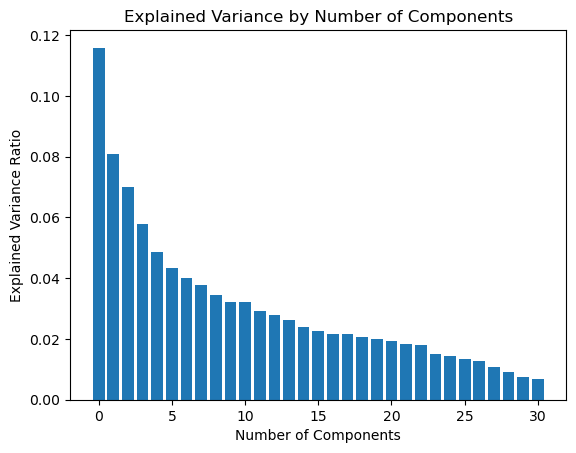

In [68]:
features = range(pca_fit.n_components_)
plt.bar(features, pca_fit.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Number of Components')
plt.show()

In [71]:
cols = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31']
loadings = pd.DataFrame(pca_fit.components_.T, columns=cols, index=X_train_num.columns)
loadings.sort_values('PC1', ascending=False)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31
dep_delay_mean_30D,0.386403,3.325652e-02,-1.240314e-02,-1.659516e-02,1.164587e-02,-4.544937e-02,7.188393e-02,-1.016792e-01,1.869440e-04,1.336057e-02,-7.013821e-02,-2.891778e-02,4.865708e-04,-4.042645e-04,4.298496e-02,2.007387e-03,-2.849138e-03,4.999305e-02,-1.843068e-02,5.171811e-03,1.708256e-02,-4.227968e-02,-4.473586e-03,-3.411838e-02,-4.603248e-02,3.734064e-03,1.517361e-01,3.447253e-01,3.136187e-02,-4.882602e-02,-7.774112e-03
dep_delay_mean_10D,0.371403,2.997176e-02,-1.208310e-02,-2.380865e-02,4.591276e-02,-7.772816e-02,1.022807e-01,-1.534932e-01,7.002069e-03,5.455660e-02,-1.097069e-01,-5.409435e-02,-1.849169e-02,-2.121884e-02,3.846210e-02,2.174521e-02,-2.426470e-03,4.866800e-02,-2.687916e-02,1.258062e-02,2.922785e-02,-4.438219e-02,4.914552e-02,1.443364e-01,3.971519e-02,7.244682e-02,-2.097809e-01,-3.152673e-01,1.135109e-01,-3.805690e-02,-6.018488e-04
dep_delay_median_10D,0.365193,8.959683e-02,-1.559488e-02,5.338638e-02,-6.549566e-02,3.488303e-02,3.273459e-02,1.105766e-01,6.883392e-02,3.412491e-02,8.705926e-02,3.571840e-02,-1.201688e-01,2.037979e-02,-1.111444e-01,-3.290841e-02,1.027676e-02,-8.721651e-02,3.988803e-02,-1.031681e-02,5.650895e-04,7.051358e-02,-1.273261e-03,3.718661e-02,3.532516e-02,7.873640e-03,-1.189853e-01,-1.856083e-01,-2.435948e-03,2.920047e-02,-2.356090e-02
dep_delay_median_30D,0.360581,9.652989e-02,-1.692761e-02,5.668690e-02,-7.559701e-02,4.493780e-02,2.148778e-02,1.286331e-01,6.426728e-02,1.470790e-02,9.609300e-02,4.537933e-02,-1.109930e-01,3.244171e-02,-1.088395e-01,-3.012621e-02,1.546716e-02,-8.999817e-02,2.810227e-02,-1.655736e-02,-4.295899e-03,7.555840e-02,-3.310139e-02,-8.018606e-02,-2.332765e-02,-4.599286e-02,1.106785e-01,1.939983e-01,-7.537558e-03,-4.807500e-02,2.246257e-03
arr_delay_median_10D,0.357945,1.011903e-01,6.660682e-04,6.352240e-02,-2.673832e-02,2.969279e-02,-2.850241e-02,1.312825e-01,7.268870e-02,6.262218e-02,6.956173e-02,3.140581e-02,-8.014299e-02,1.544227e-02,-1.284275e-01,-2.830753e-02,8.846265e-03,-9.905756e-02,4.246048e-02,-1.480609e-03,-8.199899e-03,8.080996e-02,-1.021141e-02,2.505772e-02,4.759746e-02,-2.494605e-03,-1.224076e-01,-1.733456e-01,-3.647141e-02,9.185285e-02,-1.949309e-03
arr_delay_median_30D,0.355968,1.125866e-01,1.269579e-03,6.520030e-02,-3.593675e-02,4.267537e-02,-5.024469e-02,1.467169e-01,6.276624e-02,4.213136e-02,7.086503e-02,4.120073e-02,-6.226709e-02,2.669602e-02,-1.202643e-01,-3.023037e-02,1.348589e-02,-9.656898e-02,3.243791e-02,-7.106828e-03,-1.495587e-02,8.296930e-02,-3.631190e-02,-8.796329e-02,-1.007626e-02,-5.490875e-02,1.015645e-01,1.934586e-01,-3.360596e-02,1.274503e-02,2.540420e-02
dep_delay_max_10D,0.209502,-5.408873e-02,-8.442015e-03,-1.248242e-01,1.927081e-01,-1.852240e-01,1.324873e-01,-3.573516e-01,-3.531130e-02,9.162354e-02,-2.467688e-01,-1.124698e-01,4.101687e-02,-4.459208e-02,7.669922e-02,4.648579e-02,-8.792350e-03,6.133895e-02,-4.837559e-02,1.468035e-02,2.409982e-02,-3.083286e-02,5.380972e-02,1.146051e-01,3.884233e-02,2.909457e-02,-1.929284e-01,-3.505885e-01,7.619550e-02,-2.406504e-02,2.801544e-02
dep_delay_max_30D,0.177094,-6.761551e-02,-9.796522e-03,-1.574205e-01,1.968270e-01,-1.849346e-01,1.121471e-01,-3.663389e-01,-5.166534e-02,6.204862e-02,-2.225937e-01,-1.047166e-01,5.982079e-02,-2.773584e-02,8.219608e-02,1.840015e-02,-1.490166e-02,6.120442e-02,-3.564058e-02,1.061980e-02,4.474600e-03,-2.200118e-02,8.536581e-03,-6.701364e-02,-4.829836e-02,-3.917223e-02,1.892724e-01,4.997147e-01,-6.950444e-02,6.497756e-02,-2.534409e-02
hour_of_day,0.162497,7.847378e-02,1.617299e-03,9.790432e-02,-1.478160e-01,1.337012e-01,-2.633746e-02,4.948290e-02,-1.390878e-01,-1.446746e-01,2.342164e-02,-2.015309e-01,-4.089438e-02,1.820178e-03,3.638462e-01,2.294699e-02,-2.835907e-02,3.171802e-01,-4.871767e-02,1.762916e-02,-1.257253e-01,-1.903449e-01,2.416286e-01,-1.826300e-01,-2.060661e-01,-2.607041e-01,3.478460e-01,-3.027403e-01,-3

In [72]:
X_train_final = np.concatenate([X_train_num_pca, X_train[cat_cols].values], axis=1)
X_test_final = np.concatenate([X_test_num_pca, X_test[cat_cols].values], axis=1)

In [73]:
logreg_model = LogisticRegression()

logreg_model.fit(X_train_final, y_train)

y_pred = logreg_model.predict(X_test_final)

print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    441319
           1       0.24      0.04      0.07      6416

    accuracy                           0.98    447735
   macro avg       0.61      0.52      0.53    447735
weighted avg       0.98      0.98      0.98    447735


[[440564    755]
 [  6173    243]]


In [52]:
rf_model = RandomForestClassifier()

rf_model.fit(X_train_final, y_train)

y_pred = rf_model.predict(X_test_final)

print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    441319
           1       0.76      0.02      0.04      6416

    accuracy                           0.99    447735
   macro avg       0.87      0.51      0.52    447735
weighted avg       0.98      0.99      0.98    447735


[[441275     44]
 [  6274    142]]


In [ ]:
model_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_test_final.columns)
model_important_features = model_important_features.sort_values('feature_importance', ascending=False)
model_important_features.head(20)

In [ ]:
gb_model = GradientBoostingClassifier()

gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)

print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))

In [45]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=30)
selector.fit(X_train, y_train)
X_train_reduced = selector.transform(X_train)

selector.get_feature_names_out

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [36 45 60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


<bound method SelectorMixin.get_feature_names_out of SelectKBest(k=30)>